# Logfile Summary 16.03.2017  - test

Here I summarize the interesting/suspicius/special logs, I found in tonights logfile. 
Maybe something similar can be part of a future auto shift summary. 

Tonight I will show less messages very verbosely and instead count them only **if** we have already seen them yesterday and *I decided* they are not very interesting... (Maybe not the best approach, but a start)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import logfile_parser

plt.rcParams["figure.figsize"] = (14, 4)
plt.rcParams["font.size"] = 14
plt.rcParams["figure.dpi"] = 120

Lets open the logfile and and see how many warnings and errors we've got tonight. We can assume errors and warnings are more imporant than infos and unmarked logs.

In [2]:
logs = logfile_parser.logfile2dataframe("20160317.log")
logs.severity.value_counts()

-    70821
I    26488
#      912
W       46
E       12
dtype: int64

## Errors

In [3]:
error_log = logs[logs.severity == "E"][["server", "message"]]
error_log.set_index("server", append=True, inplace=True)
error_log

message
time                    server                                                          
2016-03-18 02:51:49.877 FSC_CONTROL    Reading from 10.0.128.127:5000: Connection res...
2016-03-18 02:53:16.361 DIM_CONTROL    | scripts/Main.js: l.973: Error: Something une...
                        DIM_CONTROL    |         throw new Error("Something unexpecte...
                        DIM_CONTROL                                    |               ^
2016-03-18 02:53:16.365 DIM_CONTROL                                                    |
                        DIM_CONTROL    | Error: Something unexpected has happened. On...
                        DIM_CONTROL                      |     at scripts/Main.js:973:15
                        DIM_CONTROL                                    |     at main:1:1
2016-03-18 06:20:07.425 DRIVE_CONTROL  IndraDrive Az [f2026]: Undervoltage in power s...
2016-03-18 06:20:07.435 DRIVE_CONTROL  IndraDrive Zd [f2026]: Undervoltage in power s...
2016-03-18 06:20:07.495 DRIVE_CONTROL               IndraDrive Zd [f8070]: 24V DC error!
2016-03-18 06:25:08.213 DRIVE_CONTROL  Reading from sps:5357: Connection timed out (s...

* Around 2:52h the FSC was making problems again and Main.js threw an exception. 
    * Btw. the *shifthelper* called me nicely but I was in the kitchen and needed some time to restart Main.js ...) 

* In the morning the typical "morning error" of the drive. 
    * Need to find a nice way to filter these errors from the other errors

## Warnings

In [4]:
warnings = logs[logs.severity == "W"]

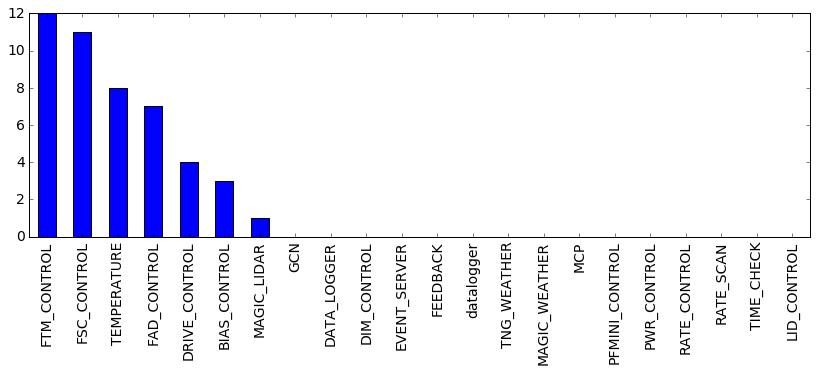

In [5]:
warnings.server.value_counts().plot.bar()

Lets start from left to right.

In [6]:
warnings.query("server == 'FTM_CONTROL'").message.value_counts()

SET_SELECTED_THRESHOLDS: Not allowed in state Valid[4]... ignored.    10
STOP_TRIGGER: Not allowed in state Valid[4]... ignored.                2
Name: message, dtype: int64

You remember yesterday? FTM_CONTROL was only telling us, that somehow the command "SET_SELECTED_THRESHOLDS" was sent at inappropriate times. Today we also get "STOP_TRIGGER" was sent at inappropriate times.

In [7]:
warnings.query("server == 'FSC_CONTROL'").message.str.slice(0, 14).value_counts()

Checksum error    10
Connecting to      1
Name: message, dtype: int64

So we get the typical Checksum errors, and once we lost the connection entirely. Which lead to the need to restart Main.js. We have already seen that in the errors. (In case you wonder, why I slice the messages before counting them. The *Checksum error* messages contain details about what exactly did not work. So if I counted the entire message, each message would be different.

In [8]:
warnings.query("server == 'TEMPERATURE'").message.value_counts()

Parsing of JSON failed: <unspecified file>(1): expected ',' or '}'    8
Name: message, dtype: int64

Nothing new ... our friend TEMPERATURE has the same problems today as it had yesterday.

In [9]:
warnings.query("server == 'FAD_CONTROL'").message.value_counts()

Could not reset DRS calibration of secondary baseline.    7
Name: message, dtype: int64

Did we see that yesterday as well? I must have overlooked it. To much information, clearly shows the need for a concise summary. I hope you agree. Well lets have a look at *when* this happened.


In [10]:
warnings.query("server == 'FAD_CONTROL'").index

DatetimeIndex(['2016-03-17 21:23:43.621000', '2016-03-17 22:48:41.317000',
               '2016-03-18 00:13:54.582000', '2016-03-18 01:39:43.698000',
               '2016-03-18 02:59:44.342000', '2016-03-18 04:30:43.894000',
               '2016-03-18 05:55:44.252000'],
              dtype='datetime64[ns]', name='time', freq=None)

If you have a look at [todays Run DB](http://fact-project.org/run_db/db/fact_runinfo.php?fRunTypeName=On&fRunTypeKEY=0&fSourceName=On&fSourceKEY=0&fRunStart=On&TimeDiff%28fRunStop%2CfRunStart%29=On&fROI=On&if%28fHasDrsFile%3D0%2C%22N%22%2CfDrsStep%29=On&fStartDate=20160317&fStopDate=20160317&fNumResults=500&fSortBy=Run+) and compare the times, you can see, that these warnings occur shortly before the 3rd run of a group of DRS4 calibration runs. 

If you think back a few month, the DRS4 **amplitude** calibration run group consisted of 4 runs with these rois:
 * 1024
 * 1024
 * 1024
 * 300
 
Both the 3rd and the 4th calibrate the same thing the *TriggerOffset* aka *secondary baseline*. So between the 3rd and the 4th run, this *secondary baseline* was reset. Nowadays we usually skip (not at the beginning of the night) the 3rd run. And so we do not need to reset the *secondary baseline* anymore. Somehow the command to reset *secondary baseline* must have survived in the code of Main.js and is issued even though there is no need for it.

So we learned something today. Experts please see if you don't want to remove this command where it is not needed.

In [11]:
warnings.query("server == 'DRIVE_CONTROL'")[["message"]]

,message
time,
2016-03-17 19:54:57.571,Connecting to 192.168.1.2:5357: Connection ref...
2016-03-18 06:20:07.485,IndraDrive Az [e2819]: Main power failure!
2016-03-18 06:25:11.214,Connecting to 192.168.1.2:5357: No route to ho...
2016-03-18 06:25:23.374,PARK: Not allowed in state Locked[3]... ignored.


Again some warnings from switching on and shutting down. Not really interesting. (Need to find a way to filter this without filtering too much)

---

# The rest by frequency

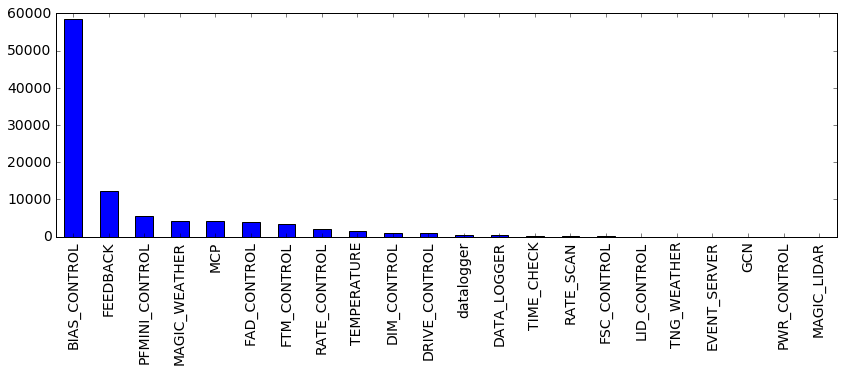

In [12]:
non_error_or_warning = logs.query("severity not in ['E', 'W']")
non_error_or_warning.server.value_counts().plot.bar()

In [13]:
bias_infos = non_error_or_warning.query("server == 'BIAS_CONTROL'")
bias_infos.message.value_counts()

Ramping: target values reached.                                                            11689
Ramping[5] by Run()                                                                        11687
State Transition from Ramping[5] to VoltageOn[9] (by Run())                                11675
VoltageOn[9] by Run()                                                                      11675
State Transition from VoltageOn[9] to Ramping[5] (by Run())                                11675
VoltageOff[7] by Run()                                                                        13
State Transition from VoltageOff[7] to Ramping[5] (by Run())                                  12
State Transition from Ramping[5] to VoltageOff[7] (by Run())                                  12
Synchronization time expired (1)                                                               1
State Transition from VoltageOff[7] to Disconnected[1] (by Run())                              1
Synchronization time expired (

In [14]:
bias_infos[bias_infos.message.str.contains("Synchro")]

,severity,server,state,message
time,,,,
2016-03-17 19:57:38.186,I,BIAS_CONTROL,NaN,Synchronization time expired (0)
2016-03-17 19:57:38.687,I,BIAS_CONTROL,NaN,Synchronization time expired (1)



I guess for a summary we could certainly remove really **all** of the infos, we see 10k times per night. We could count them, so we see when they suddenly happen 100k times instead of 10k or so...

In [15]:
feedback_infos = non_error_or_warning.query("server == 'FEEDBACK'")
feedback_infos.message.value_counts()

InProgress[8] by ExecFunc function-call (CURRENT)                                                         61
State Transition from Calibrated[6] to WaitingForData[7] (by ExecFunc function-call: START)               61
State Transition from WaitingForData[7] to InProgress[8] (by ExecFunc function-call: CURRENT)             61
WaitingForData[7] by ExecFunc function-call (START)                                                       61
State Transition from InProgress[8] to Calibrated[6] (by ExecFunc function-call: STOP)                    51
Calibrated[6] by ExecFunc function-call (STOP)                                                            51
Starting feedback with an offset of 2.38419e-08V                                                          31
Starting feedback with an offset of -1.1V                                                                 30
Calibrated[6] by ExecFunc function-call (STATE)                                                            9
State Transition fr

I have no idea what all these "dU" infos are doing here. Looks for me like *debugging print*, which one does during evaluation of a new algorithm... are we testing something new in feedback at the moment? 

I guess these can also be filtered away and maybe counted. How many are there anyway?

In [16]:
len(feedback_infos.message.str.startswith("dU("))

12127

12k ... not bad ... have fun reading all of them in order to find some fishy number ... :-)

No seriously ... tomorry these will be filtered away and counted only.

---


In [17]:
pfmini_infos = non_error_or_warning.query("server == 'PFMINI_CONTROL'")
pfmini_infos.message.value_counts()

H=20.6% T=26.1C    39
H=20.6% T=26.3C    37
H=20.6% T=26.2C    34
H=20.6% T=26.4C    34
H=20.6% T=26.5C    26
H=29.3% T=11.7C    23
H=20.7% T=26.3C    22
H=20.7% T=26.1C    22
H=20.7% T=26.4C    21
H=20.6% T=26.0C    21
H=29.5% T=11.6C    20
H=20.4% T=26.4C    20
H=29.4% T=11.4C    19
H=20.5% T=26.3C    18
H=29.3% T=11.5C    18
H=20.7% T=26.2C    18
H=29.1% T=11.7C    17
H=29.4% T=11.5C    17
H=28.7% T=11.9C    17
H=29.2% T=11.9C    17
H=29.5% T=11.4C    17
H=29.3% T=11.6C    16
H=29.2% T=11.7C    16
H=20.4% T=26.3C    16
H=29.2% T=11.4C    16
H=29.5% T=11.7C    15
H=29.5% T=11.5C    15
H=29.0% T=11.7C    15
H=20.6% T=26.6C    15
H=29.8% T=11.7C    15
                   ..
H=23.0% T=21.6C     1
H=21.9% T=24.2C     1
H=21.8% T=24.9C     1
H=25.9% T=18.9C     1
H=23.5% T=17.0C     1
H=28.3% T=15.1C     1
H=29.9% T=12.7C     1
H=26.9% T=15.6C     1
H=20.9% T=25.0C     1
H=24.6% T=17.2C     1
H=23.4% T=20.9C     1
H=23.4% T=20.1C     1
H=26.6% T=13.1C     1
H=20.7% T=25.2C     1
H=28.8% T=

**WOW** ... And I though we stored such information in fits files ... let's see if there is anything not starting with "H="

In [18]:
print("Total # of infos by PFmini:", len(pfmini_infos))
pfmini_infos = pfmini_infos[~pfmini_infos.message.str.startswith("H=")]
pfmini_infos.message.value_counts()

Total # of infos by PFmini: 5573


Series([], Name: message, dtype: int64)

Nope ... just 5.5k lines of numbers hopefully identical to the numbers in the fits file. Maybe we should switch this off.

In [19]:
non_error_or_warning.query("server == 'MAGIC_WEATHER'").message.value_counts()

12:31:28[0]: T=14C H=28.5% P=786.8hPa Td=-3.9C V=16.8km/h Vmax=24.6km/h dir=187.9       1
21:26:28[0]: T=7.8C H=17.5% P=787.3hPa Td=-15.3C V=9km/h Vmax=9.7km/h dir=178.5         1
16:28:29[0]: T=13.5C H=22.1% P=785.4hPa Td=-7.7C V=24.8km/h Vmax=24.8km/h dir=261.6     1
10:04:59[0]: T=13.1C H=14.6% P=786.8hPa Td=-13.2C V=14km/h Vmax=15.5km/h dir=222.4      1
13:57:00[0]: T=13.9C H=31% P=786.2hPa Td=-2.9C V=22.5km/h Vmax=22.5km/h dir=190.3       1
10:18:13[0]: T=13.5C H=13.4% P=786.8hPa Td=-13.9C V=19km/h Vmax=22.7km/h dir=202.5      1
11:08:01[0]: T=13.9C H=16.9% P=787hPa Td=-10.7C V=15.9km/h Vmax=20.5km/h dir=139.5      1
20:12:58[0]: T=7.9C H=23.4% P=786.5hPa Td=-11.7C V=10km/h Vmax=13km/h dir=179.9         1
18:11:14[0]: T=11.9C H=20% P=785.8hPa Td=-10.3C V=14.7km/h Vmax=14.8km/h dir=219.6      1
03:38:40[0]: T=5.5C H=28.5% P=785.8hPa Td=-11.2C V=10.1km/h Vmax=10.1km/h dir=114.1     1
02:17:29[0]: T=5.3C H=33.2% P=786.4hPa Td=-9.6C V=3.3km/h Vmax=3.3km/h dir=173.9        1
20:01:01[0

Getting more and more interesting. What are the numbers in the front? Either this logfile_parser has a bug, since the *time stamp* should definitely not be part of the *message* or MAGIC_WEATHER outpus somehow a dual timestamp. 

Let's look at the raw un parsed lines for a moment

In [20]:
import codecs
raw_lines = codecs.open("20160317.log", "r", encoding='utf-8', errors='ignore').readlines()
MW_raw_lines = [line for line in raw_lines if "MAGIC_WEATHER" in line]
MW_raw_lines[10:20]

[' -> 07:20:41.357000 - MAGIC_WEATHER: 07:20:28[0]: T=10C H=22.9% P=786.4hPa Td=-10.1C V=14.8km/h Vmax=20.7km/h dir=163.7\n',
 ' -> 07:21:11.360000 - MAGIC_WEATHER: 07:20:59[0]: T=10C H=22.2% P=786.4hPa Td=-10.6C V=18.1km/h Vmax=24.1km/h dir=169.4\n',
 ' -> 07:21:26.362000 - MAGIC_WEATHER: 07:21:13[0]: T=10C H=22.4% P=786.4hPa Td=-10.5C V=17.3km/h Vmax=24.1km/h dir=163.7\n',
 ' -> 07:21:41.363000 - MAGIC_WEATHER: 07:21:27[0]: T=9.9C H=22.6% P=786.4hPa Td=-10.4C V=13.6km/h Vmax=17.3km/h dir=166.9\n',
 ' -> 07:22:11.366000 - MAGIC_WEATHER: 07:22:01[0]: T=9.9C H=22.4% P=786.4hPa Td=-10.5C V=18.5km/h Vmax=18.5km/h dir=177.2\n',
 ' -> 07:22:26.367000 - MAGIC_WEATHER: 07:22:15[0]: T=9.9C H=22.4% P=786.4hPa Td=-10.5C V=15.8km/h Vmax=18.5km/h dir=131.2\n',
 ' -> 07:22:41.369000 - MAGIC_WEATHER: 07:22:26[0]: T=9.9C H=22.4% P=786.4hPa Td=-10.5C V=15.6km/h Vmax=22.5km/h dir=145.5\n',
 ' -> 07:23:11.372000 - MAGIC_WEATHER: 07:23:00[0]: T=9.9C H=21.4% P=786.4hPa Td=-11.1C V=25km/h Vmax=25km/h dir=1

Yes, there is another time stamp in those lines .. okay so the parser is not entirely useless. 

Ok. So ... erm ... I guess this could also be switched off, since it should be written in exactly the same manner into the fits aux file, right?

In [21]:
non_error_or_warning.query("server == 'MCP'").message.value_counts()

Configuring1[7] by ExecFunc function-call (START)                                      204
Configuring3[9] by Execute-command                                                     204
Configuring FAD                                                                        204
State Transition from Configuring3[9] to Configured[14] (by Execute-command)           204
Configured[14] by Execute-command                                                      204
Configuring2[8] by Execute-command                                                     204
State Transition from Configuring2[8] to Configuring3[9] (by Execute-command)          204
Starting Trigger (FTM)                                                                 204
State Transition from TriggerOn[15] to TakingData[16] (by Execute-command)             204
State Transition from Idle[5] to Configuring1[7] (by ExecFunc function-call: START)    204
Configuring Trigger (FTM)                                                              204

Now this is nice ... we can see how many data runs we have taken tonight and such things. It is pretty concise. I think this might make for a good start of the shift summary. At least part of it. 

---

In [22]:
non_error_or_warning.query("server == 'FAD_CONTROL'").message.value_counts()

Configuring3[7] by Run()                                                                                    204
Run successfully started... first data received.                                                            204
State Transition from Connected[4] to Configuring1[5] (by ExecFunc function-call: CONFIGURE)                204
State Transition from Configuring2[6] to Configuring3[7] (by Run())                                         204
State Transition from Configuring1[5] to Configuring2[6] (by Run())                                         204
Configured[8] by Run()                                                                                      204
State Transition from Configuring3[7] to Configured[8] (by Run())                                           204
Configuring1[5] by ExecFunc function-call (CONFIGURE)                                                       204
Configuring2[6] by Run()                                                                                

This is not so interesting I guess. Most of the stuff reported here was already visible in the MCP messages, which makes a lot of sense. Do you think the numbers should be checked? Like: MCP started 204 times to configure the FADs, and the FADs reacted exactly 204 times on it? No ... this is not interesting... if it does not work, we get an exception anyway...

In [23]:
non_error_or_warning.query("server == 'FTM_CONTROL'").message.value_counts()

Sending stop trigger.                                                                                237
Configured1[8] by Run()                                                                              205
State Transition from Configuring2[7] to Configured1[8] (by Run())                                   205
Sending new configuration was successfull.                                                           205
Configuring1[6] by ExecFunc function-call (CONFIGURE)                                                205
Trigger successfully disabled... sending new configuration.                                          205
State Transition from Configuring1[6] to Configuring2[7] (by Run())                                  205
Configuring2[7] by Run()                                                                             205
Configured2[9] by ExecFunc function-call (START_TRIGGER)                                             204
TriggerOn[5] by Run()                                  

In [24]:
rate_infos = non_error_or_warning.query("server == 'RATE_CONTROL'")
rate_infos.message.value_counts()

Stop received.                                                                                            176
Connected[4] by ExecFunc function-call (STOP)                                                             176
InProgress[7] by Execute-command                                                                          135
State Transition from GlobalThresholdSet[6] to InProgress[7] (by Execute-command)                         135
Calibrating[5] by ExecFunc function-call (CALIBRATE_RUN)                                                  134
GlobalThresholdSet[6] by ExecFunc function-call (STATIC_DATA)                                             134
State Transition from Connected[4] to Calibrating[5] (by ExecFunc function-call: CALIBRATE_RUN)           134
State Transition from Calibrating[5] to GlobalThresholdSet[6] (by ExecFunc function-call: STATIC_DATA)    134
Rate calibration by current with min. threshold of 290.                                                   134
State Tran

Okay ... these "Measured average current [...] mininum threshold set to" look suspiciously like debuging output. ... Are we developing ratecontrol at the moment? Let me try and filter out some of them

In [25]:
rate_infos = rate_infos[~rate_infos.message.str.startswith("Measured average current")]
rate_infos = rate_infos[~rate_infos.message.str.contains("individual thresholds")]
rate_infos.message.value_counts()

Stop received.                                                                                            176
Connected[4] by ExecFunc function-call (STOP)                                                             176
State Transition from GlobalThresholdSet[6] to InProgress[7] (by Execute-command)                         135
InProgress[7] by Execute-command                                                                          135
Calibrating[5] by ExecFunc function-call (CALIBRATE_RUN)                                                  134
State Transition from Connected[4] to Calibrating[5] (by ExecFunc function-call: CALIBRATE_RUN)           134
Rate calibration by current with min. threshold of 290.                                                   134
GlobalThresholdSet[6] by ExecFunc function-call (STATIC_DATA)                                             134
State Transition from Calibrating[5] to GlobalThresholdSet[6] (by ExecFunc function-call: STATIC_DATA)    134
State Tran

See that? These messages containing "Run-type * not found", I think this sounds a bit like it is actually a warning. At least I would like to know what is going on there, because to me this sounds like RATE_CONTROL was searching in the configuration DB for some settings regarding a certain run-type and could not find any, thus falling back to default settings. And I wonder if the default settings arw actually apropriate for each of those run-types... 

Experts, could you please comment on that? I'm sure it just sounds bad, since we are running like this for quite some time now. But maybe you can clarify what it means.

In [26]:
non_error_or_warning.query("server == 'TEMPERATURE'").message.value_counts()

T=26.9C Tmin=26.3C Tmax=28.2C                                119
T=26.8C Tmin=26.3C Tmax=28.2C                                103
T=27.5C Tmin=26.3C Tmax=27.7C                                102
T=27.4C Tmin=26.3C Tmax=27.7C                                101
T=27.3C Tmin=26.3C Tmax=27.7C                                 97
T=26.7C Tmin=26.3C Tmax=28.2C                                 86
T=27C Tmin=26.3C Tmax=28.2C                                   82
T=27.1C Tmin=26.3C Tmax=27.7C                                 68
T=27.2C Tmin=26.3C Tmax=27.7C                                 68
T=26.6C Tmin=26.3C Tmax=28.2C                                 51
T=27.1C Tmin=26.3C Tmax=28.2C                                 48
T=27.4C Tmin=26.3C Tmax=27.8C                                 43
T=27.3C Tmin=26.3C Tmax=28.2C                                 35
T=27.2C Tmin=26.3C Tmax=27.8C                                 34
T=27.3C Tmin=26.3C Tmax=27.8C                                 33
T=27C Tmin=26.3C Tmax=27.

And here we have again our friend the txt-backup for fits aux files. Maybe this can be switched off as well?

Dear friends .. if you made it this far ... hold tight ... we're nearly there! :-D

In [27]:
non_error_or_warning.query("server == 'DIM_CONTROL'").message.value_counts()

Voltage stable within limits                                                     114
Waiting for voltage to be stable.                                                114
Stoping feedback.                                                                 51
Switching voltage to Uov=1.1V.                                                    31
Switching voltage to Uov=0V.                                                      30
Starting calibration.                                                             29
Pointing telescope to 'Mrk 421' [wobble=2]                                         9
Voltage off.                                                                       9
Switching voltage off.                                                             9
Pointing telescope to 'Mrk 421' [wobble=1]                                         8
Starting DRS calibration [data]                                                    7
Last DRS calibration was 12.3min ago                             

Well this is our high level log and I guess one can learn a lot from it, not by counting, but maybe by measuring times betwenn certain things... then again ... all these run times are in the RunDB and we can also analyze that. 

I am not sure at the moment how this could be included in a shift summary ... maybe somebody else has an idea?

In [28]:
non_error_or_warning.query("server == 'DRIVE_CONTROL'").message.value_counts()

New axis status[3]: DKC-Ready RF PowerOn                                                        64
New axis status[1]: DKC-Ready RF PowerOn                                                        63
IndraDrive Zd [a0010]: Drive HALT.                                                              49
IndraDrive Zd [a0151]: Drive controlled positioning with encoder 1, lagless.                    48
IndraDrive Az [a0010]: Drive HALT.                                                              32
IndraDrive Az [a0151]: Drive controlled positioning with encoder 1, lagless.                    31
Stopping[9] by ExecFunc function-call (STOP)                                                    30
State Transition from Stopping[9] to Armed[7] (by Run())                                        30
Armed[7] by Run()                                                                               30
New axis status[1]: DKC-Ready RpmMode RF PowerOn                                                29
Tracking[1

I guess we need to get rid of all the numbers in the messages, if we want to quickly see if there are any suspicious messages in this list. At the moment I am too tired to do this.

In [29]:
non_error_or_warning.query("server == 'DATA_LOGGER'").message.value_counts()

Logging[40] AddNewRunNumber       196
WaitForRun[30] AddNewRunNumber    196
Name: message, dtype: int64

In [30]:
datalogger_infos = non_error_or_warning.query("server == 'datalogger'")
cumulative_count = 0
format_template = "{0:.<40}: {1:<10}| {2:<10}"
print(format_template.format("pattern", "count", "cumulative count"))
for pattern in [
        "State Transition from Logging", 
        "State Transition from WaitForRun", 
        "Opened"]:
    count = (datalogger_infos.message.str.contains(pattern)).sum()
    cumulative_count += count
    print(format_template.format(
            pattern, count, cumulative_count))
print("total length:", len(datalogger_infos))

pattern.................................: count     | cumulative count
State Transition from Logging...........: 196       | 196       
State Transition from WaitForRun........: 196       | 392       
Opened..................................: 97        | 489       
total length: 489


In [31]:
non_error_or_warning.query("server == 'TIME_CHECK'").message.str.slice(0, 34).value_counts()

Calling 'ntpdate -q hora.roa.es'      93
NTP: hora.roa.es returned: offset     93
Name: message, dtype: int64

In [32]:
non_error_or_warning.query("server == 'RATE_SCAN'").message.str.slice(0, 34).value_counts()

Triggers so far: 378 (0.0514344)      2
Triggers so far: 112 (0.0944911)      2
Triggers so far: 157 (0.0798087)      2
Triggers so far: 276 (0.0601929)      2
Triggers so far: 316 (0.0562544)      2
Triggers so far: 196 (0.0714286)      1
Triggers so far: 57 (0.132453)        1
90 1.24812e+07                        1
Triggers so far: 243 (0.06415)        1
Triggers so far: 239 (0.0646846)      1
50 1.25734e+07                        1
Triggers so far: 86 (0.107833)        1
Triggers so far: 69 (0.120386)        1
Triggers so far: 263 (0.0616626)      1
Triggers so far: 284 (0.0593391)      1
360 9.48863e+06                       1
Triggers so far: 44 (0.150756)        1
Triggers so far: 369 (0.0520579)      1
460 661380                            1
Triggers so far: 92 (0.104257)        1
Triggers so far: 216 (0.0680414)      1
Rate scan finished.                   1
550 31584                             1
Triggers so far: 63 (0.125988)        1
Triggers so far: 143 (0.0836242)      1


this is logged as well right? The "triggers so far" can be taken from FTM reports, right? 


In [33]:
non_error_or_warning.query("server == 'FSC_CONTROL'").message.value_counts()

Trying to connect to 10.0.128.127:5000...                           12
Connection established to 10.0.128.127:5000...                      11
Connection closed to 10.0.128.127:5000.                             11
Connected[2] by Run()                                                2
State Transition from Disconnected[1] to Connected[2] (by Run())     2
State Transition from Connected[2] to Disconnected[1] (by Run())     2
Disconnected[1] by Run()                                             2
Name: message, dtype: int64

In [34]:
non_error_or_warning.query("server == 'LID_CONTROL'").message.value_counts()

Moving[10] by ExecFunc function-call (CLOSE)                                       2
State Transition from Moving[10] to Closed[8] (by Run())                           2
State Transition from Open[9] to Moving[10] (by ExecFunc function-call: CLOSE)     2
Closed[8] by Run()                                                                 2
State Transition from Moving[10] to Open[9] (by Run())                             2
Open[9] by Run()                                                                   2
Moving[10] by ExecFunc function-call (OPEN)                                        2
State Transition from Closed[8] to Moving[10] (by ExecFunc function-call: OPEN)    2
Name: message, dtype: int64

In [35]:
non_error_or_warning.query("server == 'TNG_WEATHER'").message.value_counts()

Dust: 19.2ug/m^3 [2016-Mar-17 16:12:12]     1
Dust: 1.57ug/m^3 [2016-Mar-18 06:06:54]     1
Dust: 1.64ug/m^3 [2016-Mar-18 00:06:32]     1
Dust: 4.25ug/m^3 [2016-Mar-17 20:07:21]     1
Dust: 0.737ug/m^3 [2016-Mar-17 22:06:26]    1
Dust: 0.558ug/m^3 [2016-Mar-18 04:06:47]    1
Dust: 18.4ug/m^3 [2016-Mar-17 12:11:58]     1
Dust: 6.81ug/m^3 [2016-Mar-17 18:07:16]     1
Dust: 0.454ug/m^3 [2016-Mar-18 02:06:38]    1
Dust: 19ug/m^3 [2016-Mar-17 14:12:03]       1
Dust: 9.51ug/m^3 [2016-Mar-17 08:11:48]     1
Dust: 18.7ug/m^3 [2016-Mar-17 10:11:52]     1
Name: message, dtype: int64

... this is logged to an aux file as well, right?

In [36]:
non_error_or_warning.query("server == 'EVENT_SERVER'").message.value_counts()

File /daq/aux/2016/03/16/20160316.FAD_CONTROL_EVENT_DATA.fits open.    6
State Transition from Standby[2] to Running[3] (by Execute-command)    1
Standby[2] by Execute-command                                          1
Running[3] by Execute-command                                          1
State Transition from Running[3] to Standby[2] (by Execute-command)    1
Name: message, dtype: int64

In [37]:
non_error_or_warning.query("server == 'GCN'").message.value_counts()

Valid[3] by Run()                                                      1
State Transition from Connected[2] to Valid[3] (by Run())              1
State Transition from Valid[3] to Connected[2] (by HandleTrigger())    1
Connected[2] by HandleTrigger()                                        1
Name: message, dtype: int64

In [38]:
non_error_or_warning.query("server == 'PWR_CONTROL'").message.value_counts()

State Transition from SystemOn[28] to DriveOff[12] (by Run())    1
SystemOn[28] by Run()                                            1
State Transition from DriveOff[12] to SystemOn[28] (by Run())    1
DriveOff[12] by Run()                                            1
Name: message, dtype: int64

In [39]:
non_error_or_warning.query("server == 'MAGIC_LIDAR'").message.value_counts()

Series([], Name: message, dtype: int64)

Okay .. we're done. We have had a look at the entire log-file of tonight.... I think we are still far away from being able to convert the logfile into a **short** part of the entire shift summary. But I think we have found quite some potential for shortening. 

For tomorrows logfile summary, I will try to write little functions, one for every server, which basically contains "what I think is interesting and how to show it". By writing this "opinion" into a little function, I basically create a documentation for the behaviour of a certain server.

Assume there was a function called `summarize_datalogger()` which looked like this:

    cumulative_count = 0
    for pattern in [
            "State Transition from Logging", 
            "State Transition from WaitForRun", 
            "Opened"]:
        count = (datalogger_infos.message.str.contains(pattern)).sum()
        cumulative_count += count
        print("{0:.<40}: {1} {2}".format(
                pattern, count, cumulative_count))
    print("total length:", len(datalogger_infos))

    if cumulative_count != len(datalogger_infos):
        print("Note! There  were more messages in the datalogger info than the typical 3")

And assume further I left the collaboration. Then whoever reads this code, can immedieatly see, what former FACTies believed was normal behaviour for the datalogger and what not.

So by creating a collection of functions, which provide some sort of summary, we also provide some sort of documentation of expected behaviour. And I think this is very worthwhile. Actually it is certainly not me, who is best suited of writing these summary functions, but never the less, I will start doing so. 

Best suited would be probably every subsystem expert... So if you feel, that I am doing a bad job here, please alter these functions the way you like.

Thanks for reading this far... :-D ... writing it was also not fun, believe me.